In [1]:
import os
import glob
import cv2
import shutil
import numpy  as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
from PIL        import Image
from tensorflow import keras
from skimage.io import imread
from sklearn.model_selection import train_test_split

# Table of Contents

[Data Prep](#Creating-Dataframe)</br>
[Model Creation](#Model-Creation)</br>
[Training](###Training-prep)</br>
[Testing AlexNet Model](##AlexNet-Model)</br>
[Testing Simple CNN Model](###Simple-CNN-model)</br>

# Creating Dataframe

## Variables

In [2]:
# Directories
# dataDir = './data'
dataDir = '.\data'
# Dataframe
df = pd.DataFrame(data={
    "bird":[],"cat":[],"dog":[],"path":[]
    })
df['bird'] = df['bird'].astype(np.int8)
df['cat']  = df['cat'].astype(np.int8)
df['dog']  = df['dog'].astype(np.int8)
df['path'] = df['path'].astype(np.str0)

animals = ['cat','dog','bird']

## Filling Dataframe

In [3]:
for animal in animals:
    for dirname,_,filenames in os.walk(os.path.join(dataDir,animal)):
        for file in filenames:
            try:
                path = os.path.join(dataDir,animal,animal,file)
                df = pd.concat(
                    [ df,
                        pd.DataFrame({
                            'dog':  1 if animal == 'dog' else 0,
                            'cat':  1 if animal == 'cat' else 0,
                            'bird': 1 if animal == 'bird' else 0,
                            'path': [path]
                        })
                    ],
                    ignore_index=True
                )
            except:
                print("Issue at filename: ", file)

# Model Creation

### Train/Test Split

In [254]:
dataTrain, dataTest = train_test_split(
    df,
    train_size=0.2
)

### Variables

In [4]:
dirTrain = "trainData"
dirTest  = "testData"
dirValidation = "validationData"
root = "./output"

### Creating directories

In [59]:
def createDirectories(dir):
    os.makedirs(os.path.join(root,'dataset',dir))
    for animal in animals:   
        os.makedirs(os.path.join(root,'dataset',dir,animal))

In [60]:
# Create directories if they haven't already been created
if os.path.isdir(os.path.join(root,'dataset')) == False:
    os.makedirs(os.path.join(root,'dataset'))

# Training directories
if os.path.isdir(os.path.join(root,'dataset',dirTrain)) == False:
    createDirectories(dirTrain)
    
# Testing directories
if os.path.isdir(os.path.join(root,'dataset',dirTest)) == False:
    createDirectories(dirTest)

### Adding images to train/test folder

In [53]:
def folderPrep(row,dir):
    head, tail = os.path.split(row.path)
    if row.bird  == 1:
        newPath  = os.path.join(root,'dataset',dir,'bird',tail)
    elif row['cat'] == 1:
        newPath    = os.path.join(root,'dataset',dir,'cat',tail)
    elif row.dog == 1:
        newPath  = os.path.join(root,'dataset',dir,'dog',tail)
    shutil.copyfile(row.path,newPath)    
    return newPath

In [255]:
dataTrain['path'] = dataTrain.apply(folderPrep,axis=1,dir=dirTrain)

In [256]:
dataTest['path'] = dataTest.apply(folderPrep,axis=1,dir=dirTest)

### Training prep

In [5]:
BATCH_SIZE = 256
IMG_RES    = (227,227)

In [61]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [257]:
from keras.preprocessing.image import ImageDataGenerator

image_gen =  ImageDataGenerator(
        rescale= 1.0/255.0
        )
train = image_gen.flow_from_directory(
        os.path.join(root,'dataset',dirTrain), 
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        target_size=IMG_RES
        )
validation = image_gen.flow_from_directory(
        os.path.join(root,'dataset',dirTest),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        target_size=IMG_RES
        )

Found 3202 images belonging to 3 classes.
Found 13211 images belonging to 3 classes.


In [6]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout

In [259]:
model = Sequential()
model.add(
    Conv2D(
        filters=128,
        kernel_size=11,
        activation ='relu',
        strides=4,
        input_shape =(IMG_RES[0],IMG_RES[1],3)
    )
)
model.add(MaxPool2D(3,2))
model.add(Flatten())
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation = 'softmax'))  

In [ ]:
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(train,epochs=50,validation_data=validation)

In [80]:
model.save('classification1L.h5')

# Testing

## AlexNet Model

In [7]:
from numpy.linalg import svd
alexModel = keras.models.load_model('image_classification.h5')

In [8]:
options = {
    0: 'bird',
    1: 'cat',
    2: 'dog'
}

#### Testing Dataframe

In [9]:
testingDf = df.sample(n=100)
paths = testingDf['path'].values

### SVD Compression

In [10]:
svdTotalCorrect = 0
svdConfidence = []
results = []

In [11]:
def truncateSVD(A, k):
    U, S, Vt = svd(A)
    Ak = np.dot(U[:,:k],np.dot(np.diag(S[:k]),Vt[:k,:]))
    return Ak

def compressImg(img,k):
#   Send img to matrix
    imgMatrix = np.array(list(img.getdata(band=0)))
    imgMatrix.shape = (img.size[1],img.size[0])
    imgMatrix = np.matrix(imgMatrix) 
#   Compress with SVD
    compressedMatrix = truncateSVD(imgMatrix,k)
#   Convert back to img
    compressedImg = Image.fromarray(compressedMatrix)
    return compressedImg

In [12]:
def predictAnimal(img,predModel):
    img = np.array(img).astype(np.float64)
    img = img.reshape(-1,227,227,3)
    img /= 255.
    prediction = predModel.predict(img)
    return prediction

In [13]:
def getResult(arr):
    x = np.argmax(arr)
    string = options[x]
    return string,arr[x]

In [14]:
def getAnimal(str):
    if 'cat' in str:
        return 'cat'
    elif 'dog' in str:
        return 'dog'
    elif 'bird' in str:
        return 'bird'

In [ ]:
for k in range(10,100,5):
    svdTotalCorrect = 0
    confidenceArr = []
    for path in paths:
        # Compress Image
        img  = Image.open(path).resize((227,227))
        imgC = compressImg(img,k).convert('RGB')
        # Make prediction
        prediction,confidence = getResult(predictAnimal(imgC,alexModel)[0])
        answer = getAnimal(path)
        # Add prediction confidence to array
        confidenceArr.append(confidence*100)
        # Evaluate prediction
        if prediction == answer:
            svdTotalCorrect += 1
    # Add result to result list
    results.append(svdTotalCorrect)
    # Add avg confidence to confidence results
    svdConfidence.append(np.mean(confidenceArr))

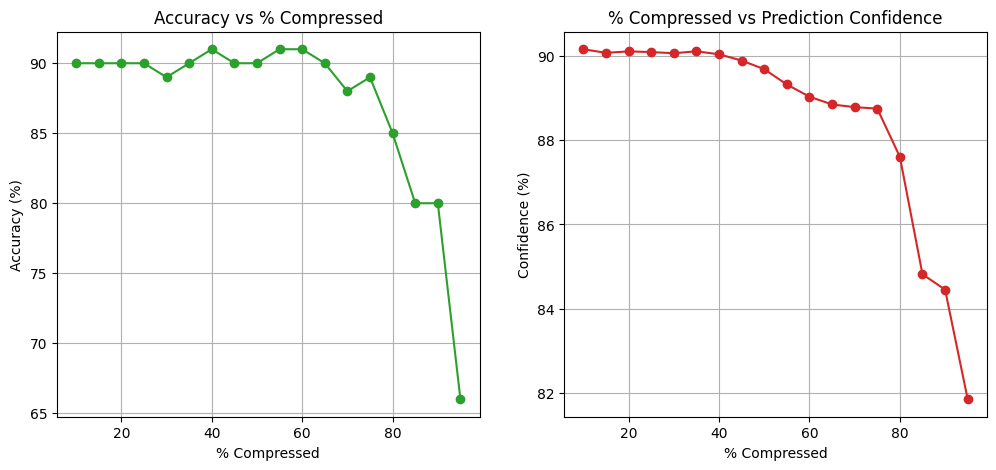

In [20]:
xVals = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
xVals = list(reversed(xVals))

fig, axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].plot(xVals,results,'tab:green',marker='o')
axs[0].set_title('Accuracy vs % Compressed')
axs[0].set(xlabel='% Compressed')
axs[0].set(ylabel='Accuracy (%)')
axs[0].grid()

axs[1].plot(xVals,svdConfidence,'tab:red',marker='o')
axs[1].set_title('% Compressed vs Prediction Confidence')
axs[1].set(ylabel='Confidence (%)')
axs[1].set(xlabel='% Compressed')
axs[1].grid()



### Resizing

In [21]:
defaultDimensions = (227,227)
resizeDimensions = [(24,24),(36,36),(48,48),(60,60),(72,72),(84,84)]
resizeTotalCorrect = 0
resizeResults = []
confidenceResults = []

In [ ]:
for size in resizeDimensions:
    resizeTotalCorrect = 0
    confidenceArr = []
    for path in paths:
        img = Image.open(path)
        # Resize image to new size
        img = img.resize(size)
        # Revert to previous size
        img = img.resize(defaultDimensions)
        # Make prediction
        prediction,confidence = getResult(predictAnimal(img,alexModel)[0])
        answer = getAnimal(path)
        # Add prediction confidence to array
        confidenceArr.append(confidence*100)
        # Evaluate prediction
        if prediction == answer:
            resizeTotalCorrect += 1
    # Add result to result list
    resizeResults.append(resizeTotalCorrect)
    # Add avg confidence to confidence results
    confidenceResults.append(np.mean(confidenceArr))

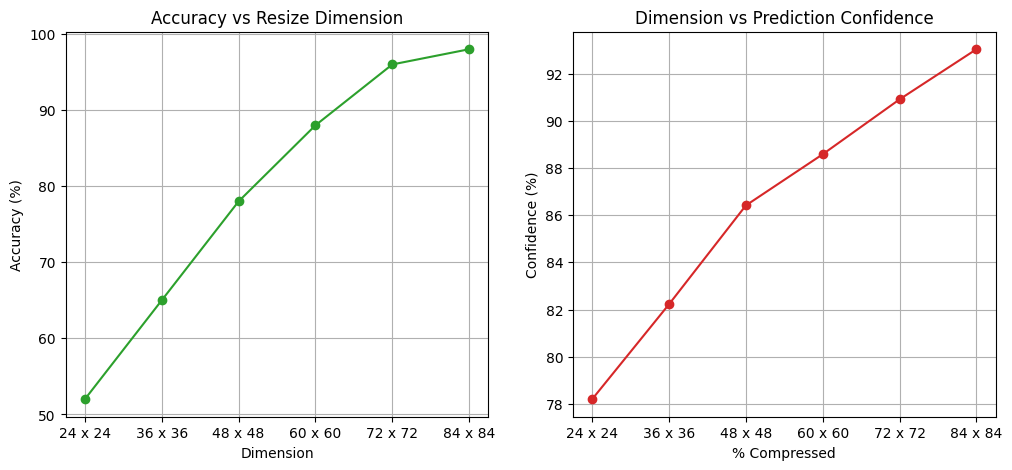

In [23]:
xr = ['24 x 24','36 x 36','48 x 48','60 x 60','72 x 72','84 x 84']

fig, axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].plot(xr,resizeResults,'tab:green',marker='o')
axs[0].set_title('Accuracy vs Resize Dimension')
axs[0].set(xlabel='Dimension')
axs[0].set(ylabel='Accuracy (%)')
axs[0].grid()

axs[1].plot(xr,confidenceResults,'tab:red',marker='o')
axs[1].set_title('Dimension vs Prediction Confidence')
axs[1].set(ylabel='Confidence (%)')
axs[1].set(xlabel='% Compressed')
axs[1].grid()

### Epsilon

In [28]:
epsilonTotalCorrect = 0
epsilonValues = range(1000,20000,1000)
epsilonResults = []
epsilonConfidence = []

In [25]:
import random

def distortImage(img,epsilon):
    x = img.shape[0]   
    for i in range(epsilon):
        p = random.randint(0,x-1)
        q = random.randint(0,x-1 )
        img[p][q][0] = 0
        img[p][q][1] = 0
        img[p][q][2] = 0
    return img

In [ ]:
for epsilon in epsilonValues:
    epsilonTotalCorrect = 0
    confidenceArr = []
    for path in paths:
        # Apply distorition to image
        img = Image.open(path).resize((227,227))
        img2 = distortImage(np.copy(img),epsilon)
        # Revert back to original shape
        img2 = img2.reshape(227,227,3)
        # Make predictions
        prediction,confidence = getResult(predictAnimal(img2,alexModel)[0])
        answer = getAnimal(path)
        # Add prediction confidence to array
        confidenceArr.append(confidence*100)
        # Evaluate predicitons
        if prediction == answer:
            epsilonTotalCorrect += 1
    epsilonResults.append(epsilonTotalCorrect)
    epsilonConfidence.append(np.mean(confidenceArr))


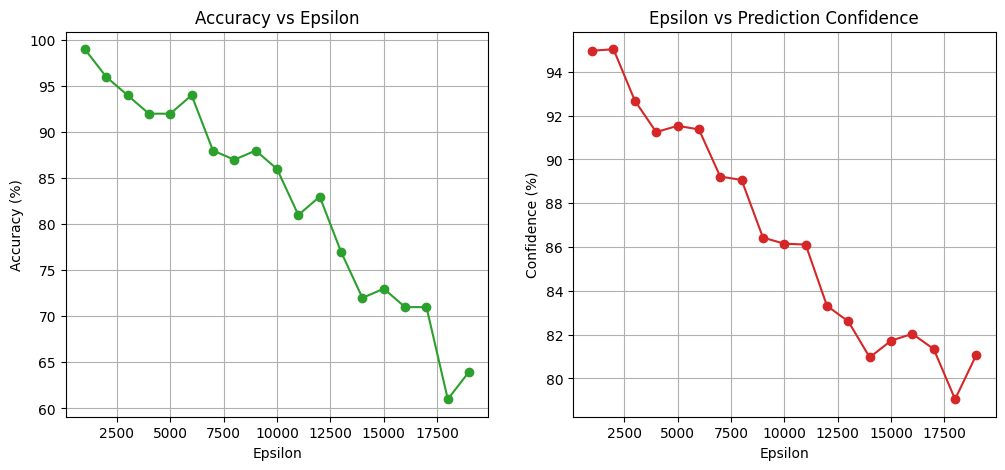

In [30]:
x = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]

fig, axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].plot(epsilonValues,epsilonResults,'tab:green',marker='o')
axs[0].set_title('Accuracy vs Epsilon')
axs[0].set(xlabel='Epsilon')
axs[0].set(ylabel='Accuracy (%)')
axs[0].grid()

axs[1].plot(epsilonValues,epsilonConfidence,'tab:red',marker='o')
axs[1].set_title('Epsilon vs Prediction Confidence')
axs[1].set(ylabel='Confidence (%)')
axs[1].set(xlabel='Epsilon')
axs[1].grid()


## Simple CNN model

In [31]:
model = keras.models.load_model('classification1L.h5')
results = []
svdConfidence = []
resizeResults = []
confidenceResults = []
epsilonResults = []
epsilonConfidence = []

### SVD Compression

In [ ]:
for k in range(10,100,5):
    svdTotalCorrect = 0
    confidenceArr = []
    for path in paths:
        # Compress Image
        img  = Image.open(path).resize((227,227))
        imgC = compressImg(img,k).convert('RGB')
        # Make prediction
        prediction,confidence = getResult(predictAnimal(imgC,model)[0])
        answer = getAnimal(path)
        # Add prediction confidence to array
        confidenceArr.append(confidence*100)
        # Evaluate prediction
        if prediction == answer:
            svdTotalCorrect += 1
    # Add result to result list
    results.append(svdTotalCorrect)
    # Add avg confidence to confidence results
    svdConfidence.append(np.mean(confidenceArr))

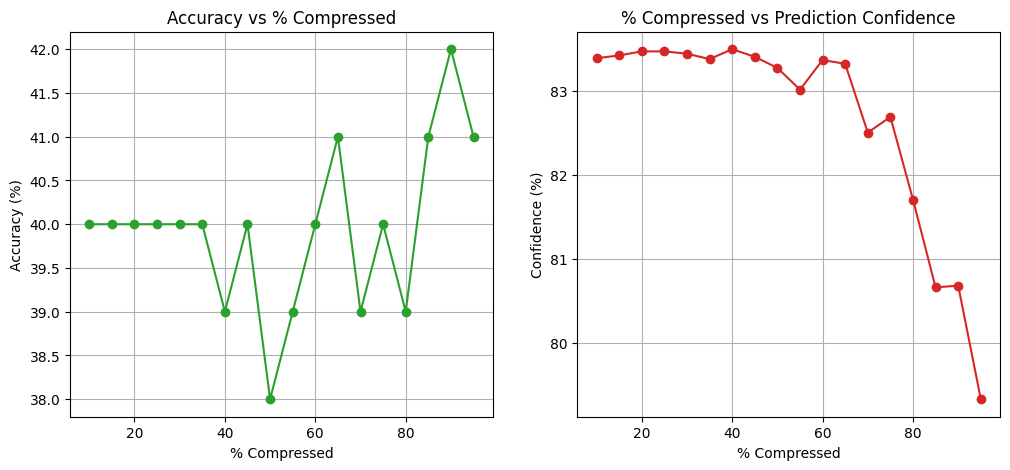

In [33]:
xVals = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
xVals = list(reversed(xVals))

fig, axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].plot(xVals,results,'tab:green',marker='o')
axs[0].set_title('Accuracy vs % Compressed')
axs[0].set(xlabel='% Compressed')
axs[0].set(ylabel='Accuracy (%)')
axs[0].grid()

axs[1].plot(xVals,svdConfidence,'tab:red',marker='o')
axs[1].set_title('% Compressed vs Prediction Confidence')
axs[1].set(ylabel='Confidence (%)')
axs[1].set(xlabel='% Compressed')
axs[1].grid()


### Resizing 

In [ ]:
for size in resizeDimensions:
    resizeTotalCorrect = 0
    confidenceArr = []
    for path in paths:
        img = Image.open(path)
        # Resize image to new size
        img = img.resize(size)
        # Revert to previous size
        img = img.resize(defaultDimensions)
        # Make prediction
        prediction,confidence = getResult(predictAnimal(img,model)[0])
        answer = getAnimal(path)
        # Add prediction confidence to array
        confidenceArr.append(confidence*100)
        # Evaluate prediction
        if prediction == answer:
            resizeTotalCorrect += 1
    # Add result to result list
    resizeResults.append(resizeTotalCorrect)
    # Add avg confidence to confidence results
    confidenceResults.append(np.mean(confidenceArr))

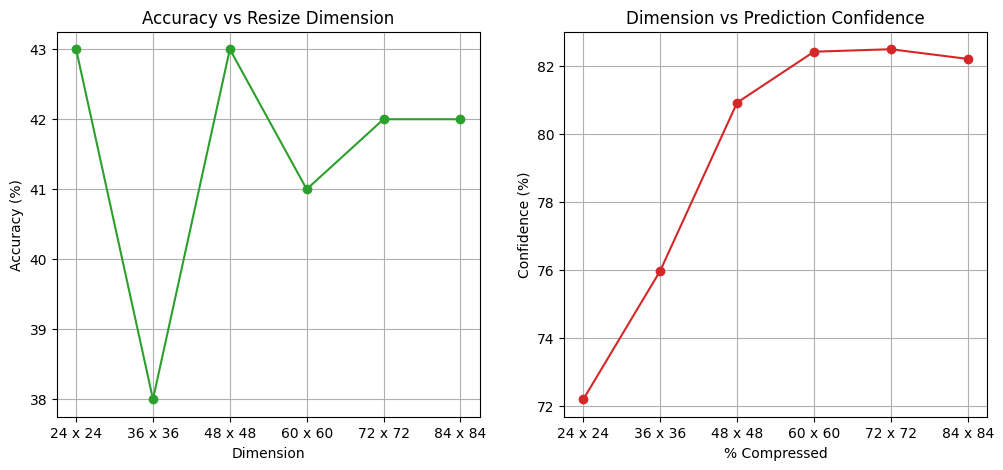

In [35]:
xr = ['24 x 24','36 x 36','48 x 48','60 x 60','72 x 72','84 x 84']

fig, axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].plot(xr,resizeResults,'tab:green',marker='o')
axs[0].set_title('Accuracy vs Resize Dimension')
axs[0].set(xlabel='Dimension')
axs[0].set(ylabel='Accuracy (%)')
axs[0].grid()

axs[1].plot(xr,confidenceResults,'tab:red',marker='o')
axs[1].set_title('Dimension vs Prediction Confidence')
axs[1].set(ylabel='Confidence (%)')
axs[1].set(xlabel='% Compressed')
axs[1].grid()

### Epsilon

In [ ]:
for epsilon in epsilonValues:
    epsilonTotalCorrect = 0
    confidenceArr = []
    for path in paths:
        # Apply distorition to image
        img = Image.open(path).resize((227,227))
        img2 = distortImage(np.copy(img),epsilon)
        # Revert back to original shape
        img2 = img2.reshape(227,227,3)
        # Make predictions
        prediction,confidence = getResult(predictAnimal(img2,model)[0])
        answer = getAnimal(path)
        # Add prediction confidence to array
        confidenceArr.append(confidence*100)
        # Evaluate predicitons
        if prediction == answer:
            epsilonTotalCorrect += 1
    epsilonResults.append(epsilonTotalCorrect)
    epsilonConfidence.append(np.mean(confidenceArr))

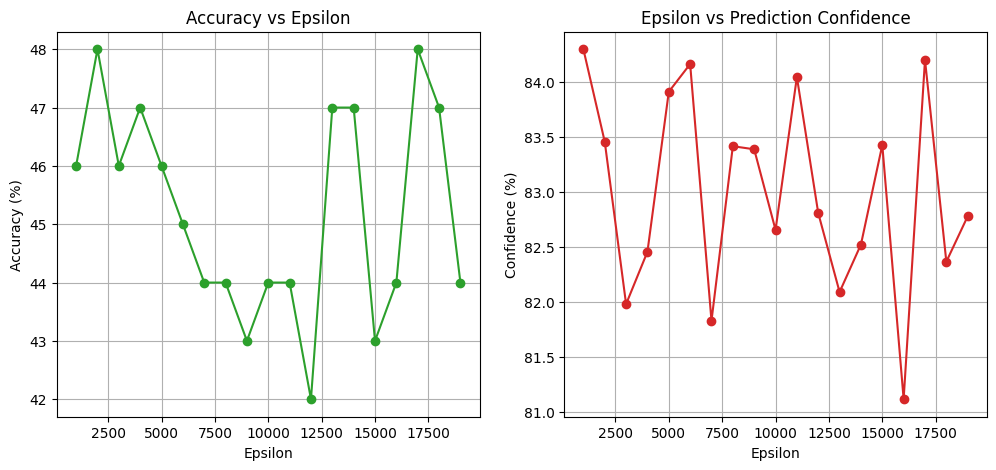

In [37]:
x = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]

fig, axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].plot(epsilonValues,epsilonResults,'tab:green',marker='o')
axs[0].set_title('Accuracy vs Epsilon')
axs[0].set(xlabel='Epsilon')
axs[0].set(ylabel='Accuracy (%)')
axs[0].grid()

axs[1].plot(epsilonValues,epsilonConfidence,'tab:red',marker='o')
axs[1].set_title('Epsilon vs Prediction Confidence')
axs[1].set(ylabel='Confidence (%)')
axs[1].set(xlabel='Epsilon')
axs[1].grid()